In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import networkx as nx
import numpy as np
from openqaoa.problems.problem import MinimumVertexCover, NumberPartition
import matplotlib.pyplot as plt
from pprint import pprint

The goal of this notebook is to showcase how the workflows work. The workflows enable the end user to run complex QAOA algorithms with a simple and intuitive API

To create a problem statement we can crate a ring a disagrees using networkx

Today we'll be solving the **Vertex cover** problem. The vertex cover of a graph is a set of vertices that includes at least one endpoint of every edge of the graph.

In [3]:
g = nx.circulant_graph(6, [1])
vc = MinimumVertexCover(g, field =1.0, penalty=10).get_pubo_problem()

The method `get_pubo_problem()` translates the problem into a binary Pubo problem. The binary values can be access via the `asdict()` method

In [4]:
vc.asdict()  

{'terms': [[0, 5],
  [0, 1],
  [1, 2],
  [2, 3],
  [3, 4],
  [4, 5],
  [0],
  [1],
  [2],
  [3],
  [4],
  [5]],
 'weights': [2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5],
 'constant': 18.0,
 'n': 6,
 'encoding': [-1, 1]}

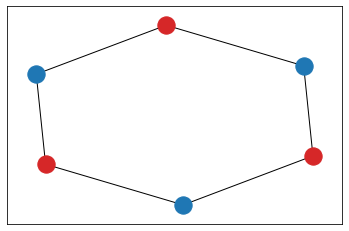

In [5]:
g = nx.circulant_graph(6, [1])
pos =  nx.spring_layout(g, seed=3113794652)
nx.draw_networkx_nodes(g, pos, nodelist=[0, 2, 4], node_color="tab:red")
nx.draw_networkx_nodes(g, pos, nodelist=[1, 3, 5 ], node_color="tab:blue")
nx.draw_networkx_edges(g, pos)

In this case the solution is 2-fold degenerate: `[1,0,1,0,1,0]` or `[0,1,0,1,0,1]`

We can then import the optimizer as follows

In [6]:
from openqaoa.workflows.optimizer import QAOA  

# Vanilla QAOA - aka vectorised

First, let's try to solve the problem using vanilla QAOA.
    
Vanilla QAOA is defined to run on the `vectorised` backend, a fast simulator for qaoa problems

In [7]:
q = QAOA()

In [8]:
q.classical_optimizer.__dict__

{'optimize': True,
 'method': 'cobyla',
 'maxiter': 100,
 'jac': None,
 'hess': None,
 'constraints': None,
 'bounds': None,
 'tol': None,
 'stepsize': None,
 'decay': None,
 'eps': None,
 'lambd': None,
 'jac_options': None,
 'hess_options': None,
 'parameter_log': True,
 'optimization_progress': False,
 'cost_progress': True,
 'top_k_solutions': 1}

After having created the QAOA object we need to compile it. **Compilation is necessary** because the QAOA solver has to interact with the problem in to be able to craete the underlying QAOA circuit

In [9]:
q.compile(vc) 

	  ### Summary ###
OpenQAOA has ben compiled with the following properties
Solving QAOA with  vectorized  on  local
Using p=1 with standard parameters initialsied as ramp
OpenQAOA will optimize using cobyla, with up to 100 maximum iterations


In [10]:
q.optimize()

optimization completed.


    To retrive the solution of the simply type

In [11]:
q.solution

'101010'

# Customising the QAOA optimiser

In [12]:
q_custom = QAOA()

The qaoa class is at first composed by 4 key sub-classes
- circuit_properties
- device_properties
- backend_properties
- classical_optimizer

Sets the circuit properties using `q.set_circuit_properties()`. Mainly used to set:

    - p: the number of layers
    - param_type: the desired parameterisation to be chosen between `['standard', 'extended', 'fourier']`
    - init_type: the initialisation stratefy for param_type. To be chosen between `[ramp, random, custom]`

In [13]:
q_custom.set_circuit_properties(p=1, param_type='standard', init_type='ramp', mixer_hamiltonian='x')

the values can be easily checked by accessing the attribute as a dictionary. Soon a better way to represent them will be provided :-)

In [14]:
q_custom.circuit_properties.__dict__

{'_param_type': 'standard',
 '_init_type': 'ramp',
 'qubit_register': [],
 '_p': 1,
 'q': None,
 'variational_params_dict': {'q': None, 'total_annealing_time': None},
 'annealing_time': 0.7,
 'linear_ramp_time': 0.7,
 '_mixer_hamiltonian': 'x',
 'mixer_qubit_connectivity': None,
 'mixer_coeffs': None,
 'seed': None}

Create and set the new device using `q.set_device()`.

The device properties include the location of the device `[local, qcs, ibmq]` and the device name. Full list of devices avaialbe at `openqaoa.workflows.parameters.qaoa_parameters.ALLOWED_DEVICES`

In [15]:
from openqaoa.devices import create_device, DeviceLocal
from openqaoa.backends.qaoa_backend import get_qaoa_backend

sim_vect = create_device(location='local', name='vectorized')

In [16]:
q_custom.set_device(sim_vect)

Sets the backend properties `q.set_backend_properties()`

Chiefly used to set the number of shots and properties fo the backend

In [17]:
q_custom.set_backend_properties(cvar_alpha=1)

Sets the classical optimiser properties `q.set_classical_optimizer()`

In [18]:
q_custom.set_classical_optimizer(method='nelder-mead', maxiter=2)

In [19]:
q_custom.compile(vc)

	  ### Summary ###
OpenQAOA has ben compiled with the following properties
Solving QAOA with  vectorized  on  local
Using p=1 with standard parameters initialsied as ramp
OpenQAOA will optimize using nelder-mead, with up to 2 maximum iterations


In [20]:
q_custom.optimize()

optimization completed.


In [21]:
q_custom.solution

'101010'

# Accessing the result information

Typying `q.results_information` provides the metadata from the classical optimisation routine. 
On our TODO list is that of turning this into a result object that can be more easily accessd

In [22]:
pprint(q_custom.results_information)

{'best cost': [14.231314973721426],
 'best count': [],
 'best param': [[0.37625, 0.37625]],
 'best probability': [{'000000': 0.005896670439492496,
                       '000001': 0.005313926085634735,
                       '000010': 0.005313926085634734,
                       '000011': 0.00503968664929711,
                       '000100': 0.005313926085634737,
                       '000101': 0.0069104886113936755,
                       '000110': 0.005039686649297108,
                       '000111': 0.01056539585134348,
                       '001000': 0.005313926085634734,
                       '001001': 0.042716592389868094,
                       '001010': 0.006910488611393676,
                       '001011': 0.026990050640433548,
                       '001100': 0.005039686649297112,
                       '001101': 0.026990050640433548,
                       '001110': 0.01056539585134349,
                       '001111': 0.014041187639292445,
                       '010000

# Test it on Pyquil's QVM

In [24]:
q_qcs = QAOA()

In [25]:
qcs_credentials = {'as_qvm':True, 'execution_timeout' : 10, 'compiler_timeout':10}

In [26]:
device = create_device(location='qcs',name='6q-qvm',**qcs_credentials)
q_qcs.set_device(device)

In [27]:
q_qcs.set_backend_properties(n_shots=500)

In [28]:
q_qcs.set_classical_optimizer(maxiter=200)

In [29]:
q_qcs.compile(vc)

	  ### Summary ###
OpenQAOA has ben compiled with the following properties
Solving QAOA with  6q-qvm  on  qcs
Using p=1 with standard parameters initialsied as ramp
OpenQAOA will optimize using cobyla, with up to 200 maximum iterations. Each iteration will contain 500 shots
The total numner of shots is set to maxiter*shots = 100000


In [30]:
q_qcs.optimize()

optimization completed.


In [31]:
q_qcs.solution

'101010'

# Qiskit - Local

In [23]:
q_qiskit_sv = QAOA()

In [24]:
qiskit_dev = create_device(location='local',name='qiskit.statevector_simulator')
q_qiskit_sv.set_device(qiskit_dev)

In [25]:
q_qiskit_sv.compile(vc)

	  ### Summary ###
OpenQAOA has ben compiled with the following properties
Solving QAOA with  qiskit.statevector_simulator  on  local
Using p=1 with standard parameters initialsied as ramp
OpenQAOA will optimize using cobyla, with up to 100 maximum iterations. Each iteration will contain 100 shots
The total numner of shots is set to maxiter*shots = 10000


In [26]:
q_qiskit_sv.optimize()

optimization completed.


In [27]:
q_qiskit_sv.solution

'010101'

### Qiskit Prepend and Append states

In [28]:
from qiskit import QuantumCircuit
qr_front = QuantumCircuit(4)
qr_back = QuantumCircuit(5)
[qr_front.ry(i,i) for i in range(4)]
qr_back.h([0,1,2,3,4])
q_qiskit_sv.set_backend_properties(prepend_state=qr_front,append_state=qr_back,init_hadamard=False)

In [29]:
qr_front.qubits

[Qubit(QuantumRegister(4, 'q'), 0),
 Qubit(QuantumRegister(4, 'q'), 1),
 Qubit(QuantumRegister(4, 'q'), 2),
 Qubit(QuantumRegister(4, 'q'), 3)]

In [30]:
q_qiskit_sv.backend_properties.__dict__

{'init_hadamard': False,
 'n_shots': 100,
 'prepend_state': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7fa61cfb88e0>,
 'append_state': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7fa61cfb8520>,
 'cvar_alpha': 1}

In [31]:
q_qiskit_sv.compile(vc)

	  ### Summary ###
OpenQAOA has ben compiled with the following properties
Solving QAOA with  qiskit.statevector_simulator  on  local
Using p=1 with standard parameters initialsied as ramp
OpenQAOA will optimize using cobyla, with up to 100 maximum iterations. Each iteration will contain 100 shots
The total numner of shots is set to maxiter*shots = 10000


In [32]:
q_qiskit_sv.optimize()

optimization completed.


In [34]:
q_qiskit_sv.solution

'111101'

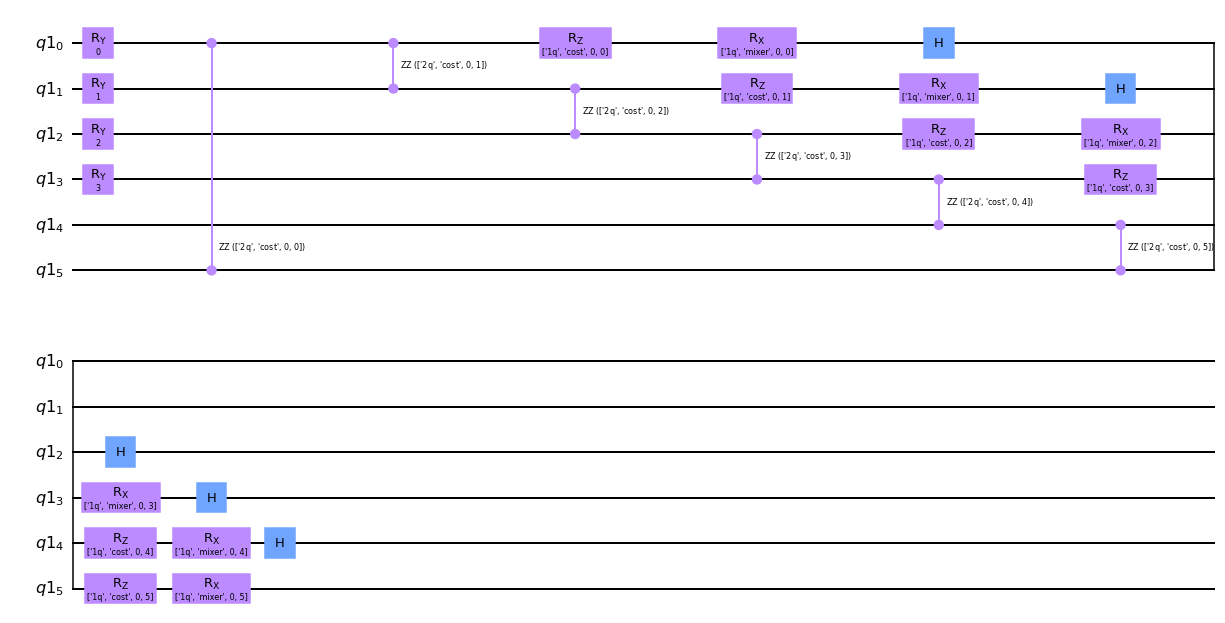

In [33]:
q_qiskit_sv.backend.parametric_circuit.draw('mpl')

# Comparing Pears and Oranges :)
That is, comparing the cost progress list of qiskit's statevector, QVMs, and vectorised 

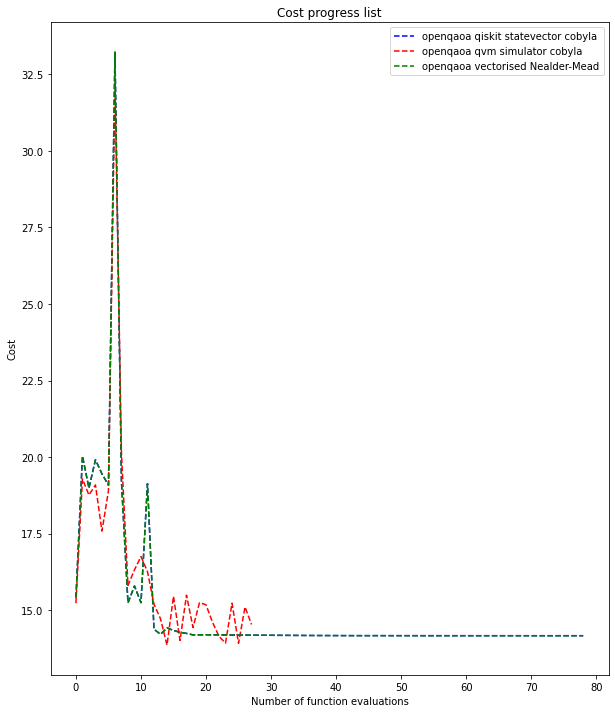

In [47]:
fig = plt.figure(figsize=(10,12))
plt.plot(range(q_qiskit_sv.results_information['number of evals']), q_qiskit_sv.results_information['cost progress list'], label = 'openqaoa qiskit statevector cobyla', linestyle = '--', color = 'b')
plt.plot(range(q_qcs.results_information['number of evals']), q_qcs.results_information['cost progress list'], label = 'openqaoa qvm simulator cobyla', linestyle = '--', color = 'r')
plt.plot(range(q.results_information['number of evals']), q.results_information['cost progress list'], label = 'openqaoa vectorised Nealder-Mead', linestyle = '--', color = 'g')

plt.ylabel('Cost')
plt.xlabel('Number of function evaluations')
plt.legend()
plt.title('Cost progress list')
plt.show()

# qiskit - on cloud 
#### (warning: This may take a long time to run depending on the availability of the cloud device!)

In [55]:
# qq = QAOA()

In [60]:
# qpu_credentials ={
# "api_token": "Enter API TOKEN",
# "hub": "ibm-q", 
# "group": "open", 
# "project": "main"}

In [61]:
# cloud_device = create_device(location='ibmq', name='simulator_statevector', **qpu_credentials)
# qq.set_device(cloud_device)

In [62]:
# qq.set_classical_optimizer(maxiter=1)

In [63]:
# qq.compile(vc) 

	  ### Summary ###
OpenQAOA has ben compiled with the following properties
Solving QAOA with  simulator_statevector  on  ibmq
Using p=1 with standard parameters initialsied as ramp
OpenQAOA will optimize using cobyla, with up to 1 maximum iterations. Each iteration will contain 100 shots
The total numner of shots is set to maxiter*shots = 100


In [64]:
# qq.optimize()

optimization completed.


In [65]:
# qq.solution

'101010'

# RQAOA

Finally, we offer a RQAOA workflow, Currently, it supports two types of RQAOA: adaptive and custom

In [6]:
from openqaoa.workflows.optimizer import RQAOA

In [7]:
g = nx.circulant_graph(8, [1])
vc = MinimumVertexCover(g, field =1.0, penalty=10).get_pubo_problem()

In [8]:
r = RQAOA(rqaoa_type = 'adaptive')

In [9]:
r.set_rqaoa_parameters(n_max=5,
                        n_cutoff = 5)

In [10]:
r.compile(vc)

In [11]:
r.optimize()

In [12]:
r.result

{'solution': {'01010101': 4.0, '10101010': 4.0},
 'classical output': {'cost min': -12.5,
  'opt strings': [array([0, 1, 0, 1, 0]), array([1, 0, 1, 0, 1])]},
 'elimination rules': [{(0, 1): -1.0, (0, 2): 1.0, (0, 7): -1.0}],
 'schedule': [3],
 'total steps': 1}

In [13]:
rr = RQAOA('custom')

In [14]:
rr.set_rqaoa_parameters(n_cutoff = 5)

In [15]:
rr.compile(vc)

In [16]:
r.optimize()

In [17]:
r.result

{'solution': {'01010101': 4.0, '10101010': 4.0},
 'classical output': {'cost min': -12.5,
  'opt strings': [array([0, 1, 0, 1, 0]), array([1, 0, 1, 0, 1])]},
 'elimination rules': [{(0, 1): -1.0, (0, 2): 1.0, (0, 7): -1.0}],
 'schedule': [3],
 'total steps': 1}